In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
import joblib

df = pd.read_csv('bank-additional-full.csv', sep=";")
df.replace('unknown', np.nan, inplace=True)
# Remove duration column because this higly affect predictions
df = df.drop('duration', axis=1)
df.head()

age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school     NaN      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         mon         1    999         0  nonexistent           1.1   
1         mon         1    999         0  nonexistent           1.1   
2         mon         1    999         0  nonexistent           1.1   
3         mon         1    999         0  nonexistent           1.1   
4         mon         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no

In [180]:
# Check missing values
import warnings
warnings.filterwarnings("ignore")
df.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

# A. Preprocess the dataset

In [181]:
# define the featuers
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                        'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                      'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

### a. Handle outliners

before Shape: (41188, 20)
after Shape: (36592, 20)


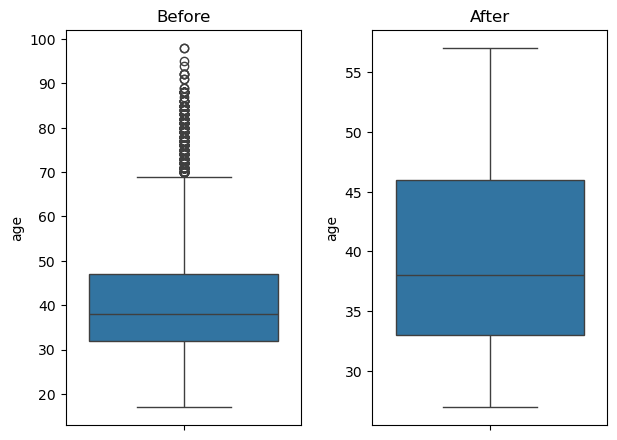

In [182]:
fig, axes = plt.subplots(1, 2)
plt.tight_layout(pad=2.0)

print("before Shape:", df.shape)

max_val = df.age.quantile(0.95)
min_val = df.age.quantile(0.05)

df2 = df[(df['age'] > min_val) & (df['age'] < max_val)].copy()
print("after Shape:", df2.shape)

sns.boxplot(df['age'], orient='v', ax=axes[0])
axes[0].set_title('Before')
sns.boxplot(df2['age'], orient='v', ax=axes[1])
axes[1].set_title('After')
df = df2
plt.show()

### a. Handle Missing Values

In [183]:
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

### b. Handle encoding for categorical features

In [184]:

cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df['y'] = df['y'].map({'no':0, 'yes':1})

### c. Scale / standarized the numberical features

In [185]:

num_scaler = StandardScaler()
df.head()

age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school     NaN      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         mon         1    999         0  nonexistent           1.1   
1         mon         1    999         0  nonexistent           1.1   
2         mon         1    999         0  nonexistent           1.1   
3         mon         1    999         0  nonexistent           1.1   
4         mon         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0          93.994          -36.4      4.857       5191.0  0  
1          93.994          -36.4      4.857       5191.0  0  
2          93.994          -36.4      4.857       5191.0  0  
3          93.994          -36.4      4.857       5191.0  0  
4          93.994          -36.4      4.857       5191.0  0

#### Data mining process with pipeline (missing values, encoding, scaling)

In [186]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', num_imputer),
            ('scaler', num_scaler)
        ]), numerical_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', cat_imputer),
            ('encoder', cat_encoder)
        ]), categorical_features)
    ])


# Separate input (X) and output (y)
X = df.drop(columns=['y'])
y = df['y']

df_before = df
# Fit and transform data
X_transformed = preprocessor.fit_transform(X)
df_transformed = pd.DataFrame(X_transformed, columns=numerical_features + categorical_features)
joblib.dump(preprocessor, "preprocessor.pkl")

df_transformed['y'] = y.values
df = df_transformed

df.head()

age  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.990074  -0.56611  0.173556 -0.336414      0.611237        0.720994   
1  2.111434  -0.56611  0.173556 -0.336414      0.611237        0.720994   
2 -0.315764  -0.56611  0.173556 -0.336414      0.611237        0.720994   
3  0.048316  -0.56611  0.173556 -0.336414      0.611237        0.720994   
4  1.990074  -0.56611  0.173556 -0.336414      0.611237        0.720994   

   cons.conf.idx  euribor3m  nr.employed  job  marital  education  default  \
0       0.940386   0.671759     0.275371  3.0      1.0        0.0      0.0   
1       0.940386   0.671759     0.275371  7.0      1.0        3.0      0.0   
2       0.940386   0.671759     0.275371  7.0      1.0        3.0      0.0   
3       0.940386   0.671759     0.275371  0.0      1.0        1.0      0.0   
4       0.940386   0.671759     0.275371  7.0      1.0        3.0      0.0   

   housing  loan  contact  month  day_of_week  poutcome  y  
0      0.0   0.0      1.0    6.0          1.0       1.0  0  
1      0.0   0.0      1.0    6.0          1.0       1.0  0  
2      1.0   0.0      1.0    6.0          1.0       1.0  0  
3      0.0   0.0      1.0    6.0          1.0       1.0  0  
4      0.0   1.0      1.0    6.0          1.0       1.0  0

In [188]:

# check null values
df.isnull().sum()

age               0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64

### c. Showing graphs for scaling before and after

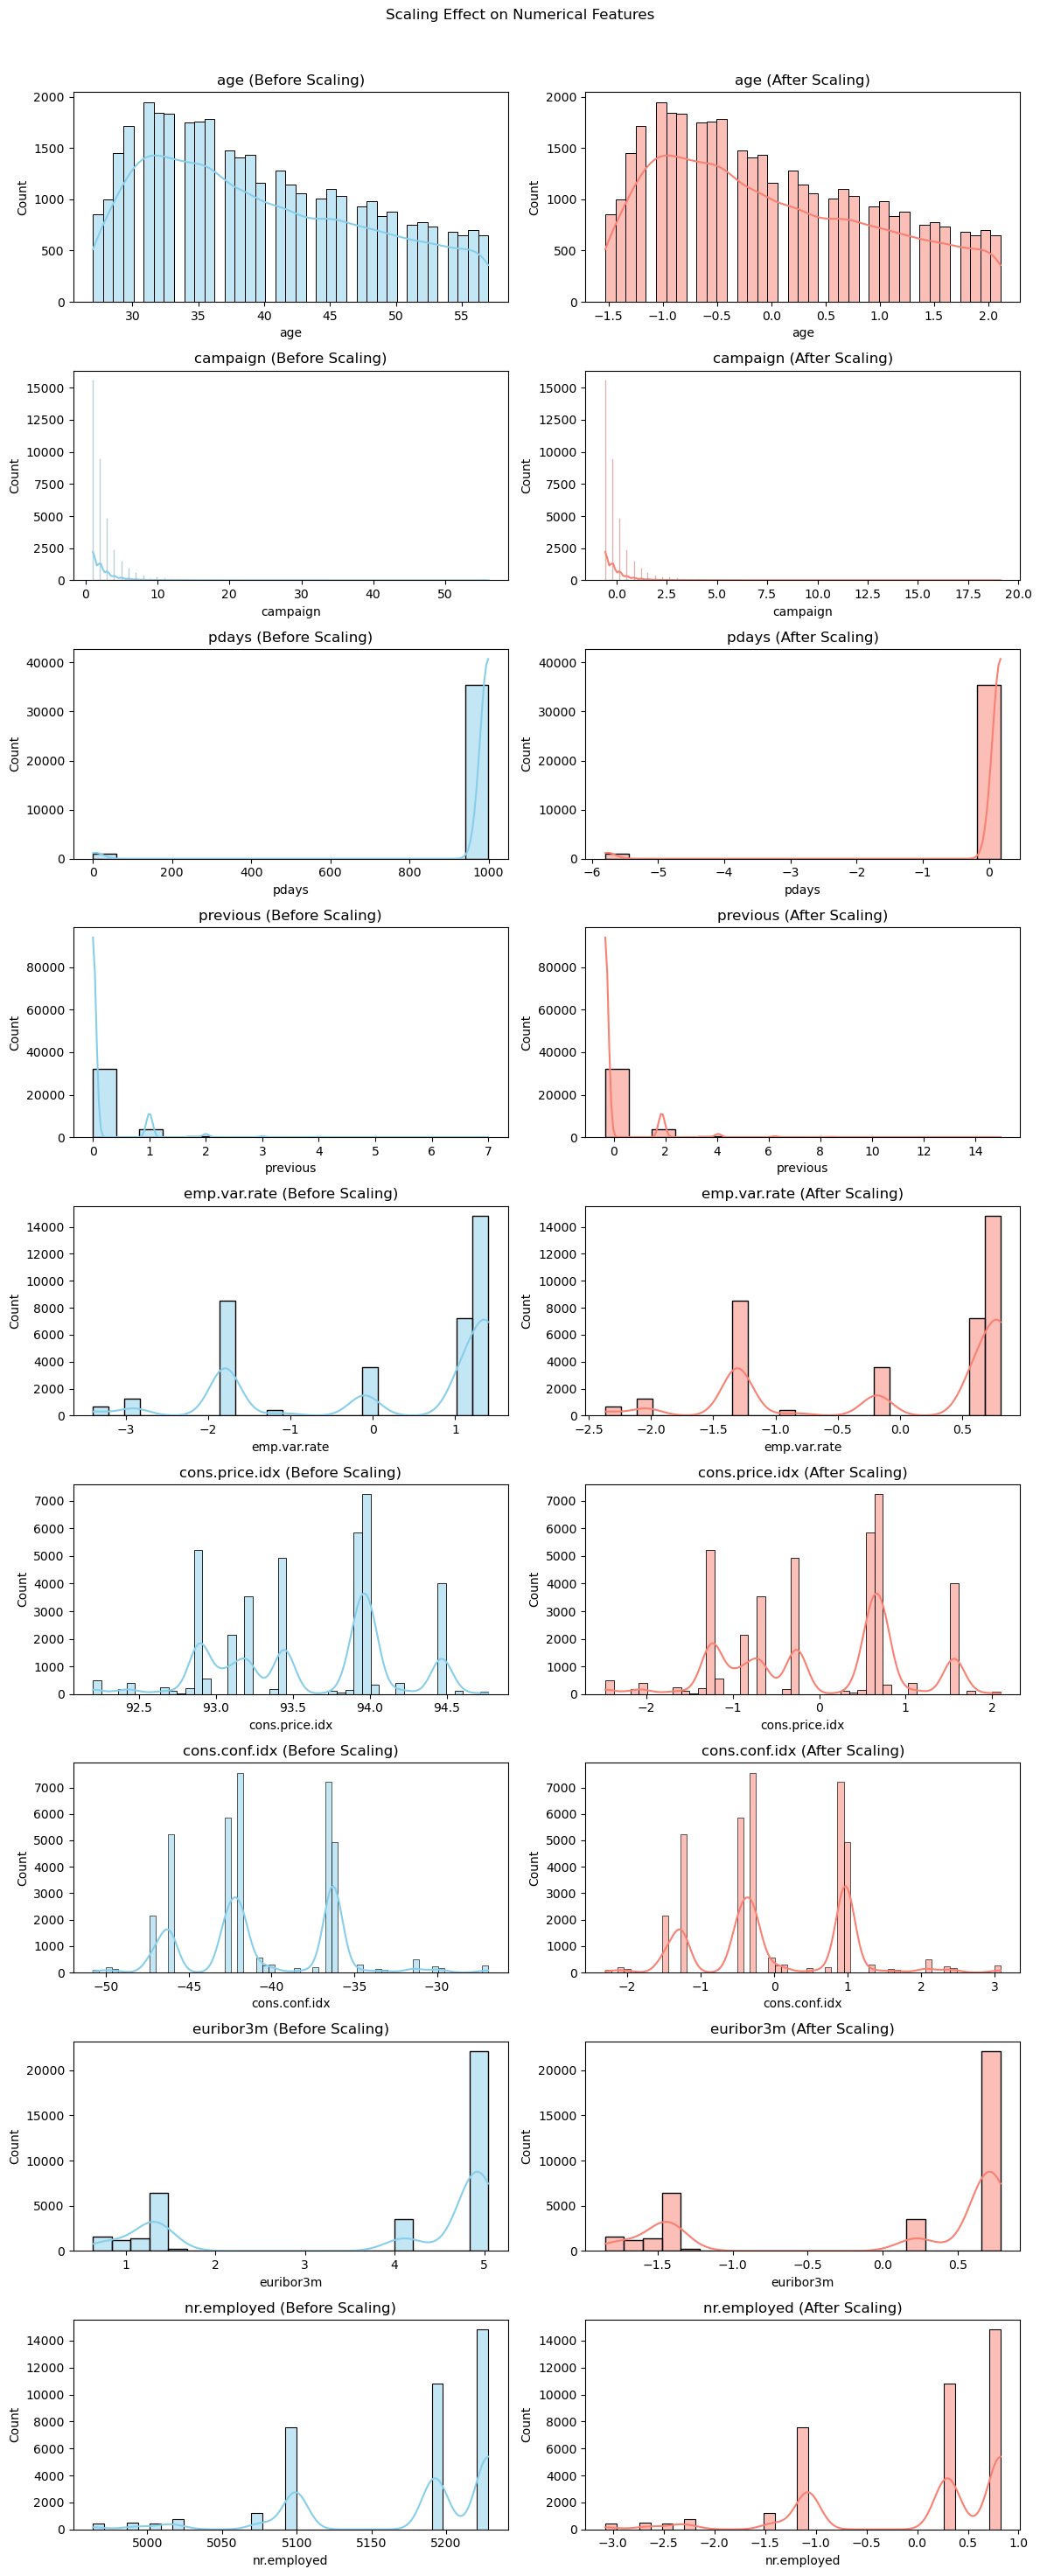

In [189]:
# Plot histograms before and after scaling
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 30))
fig.suptitle("Scaling Effect on Numerical Features", fontsize=12)

for i, col in enumerate(numerical_features):
    # Original
    sns.histplot(df_before[col], ax=axes[i, 0], kde=True, color='skyblue')
    axes[i, 0].set_title(f"{col} (Before Scaling)")
    
    # Scaled
    sns.histplot(df[col], ax=axes[i, 1], kde=True, color='salmon')
    axes[i, 1].set_title(f"{col} (After Scaling)")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Log transform skewed features

In [ ]:
# skewed_features = ['campaign', 'pdays', 'previous']
# for feature in skewed_features:
#     df[feature] = np.log1p(df[feature])

# Check by Q=Q Plot again

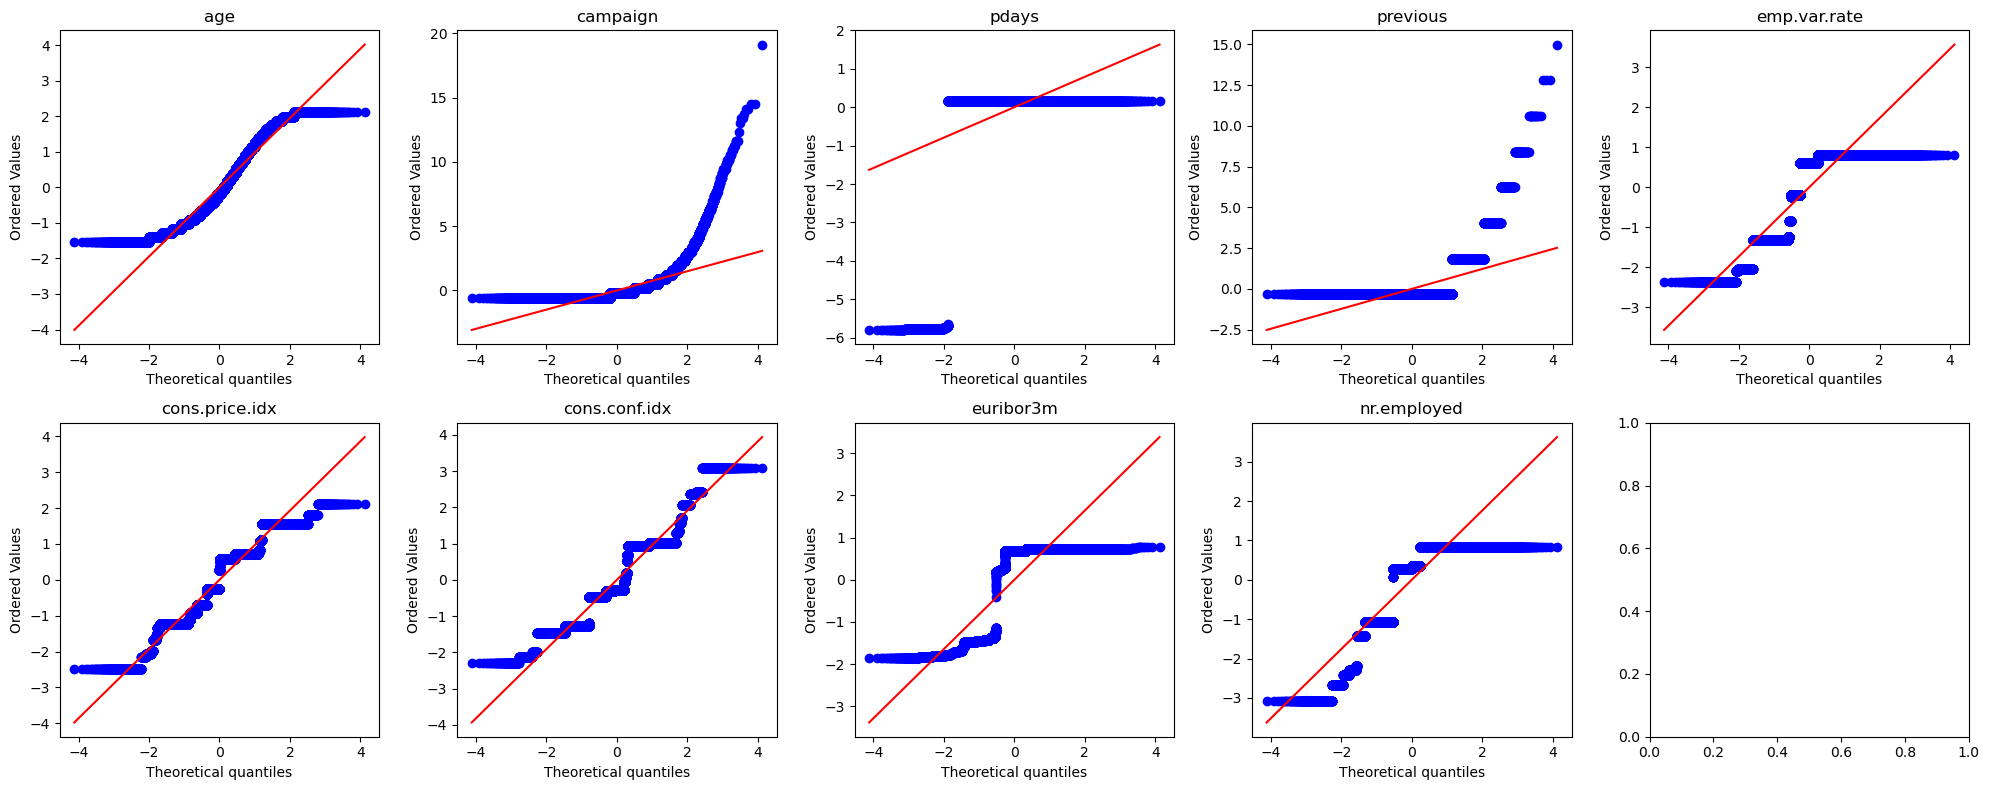

In [190]:
import scipy.stats as stats
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, feature in enumerate(numerical_features):
    row, col = i // 5, i % 5
    stats.probplot(df[feature], dist="norm", plot=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

# Check by Hist Plot

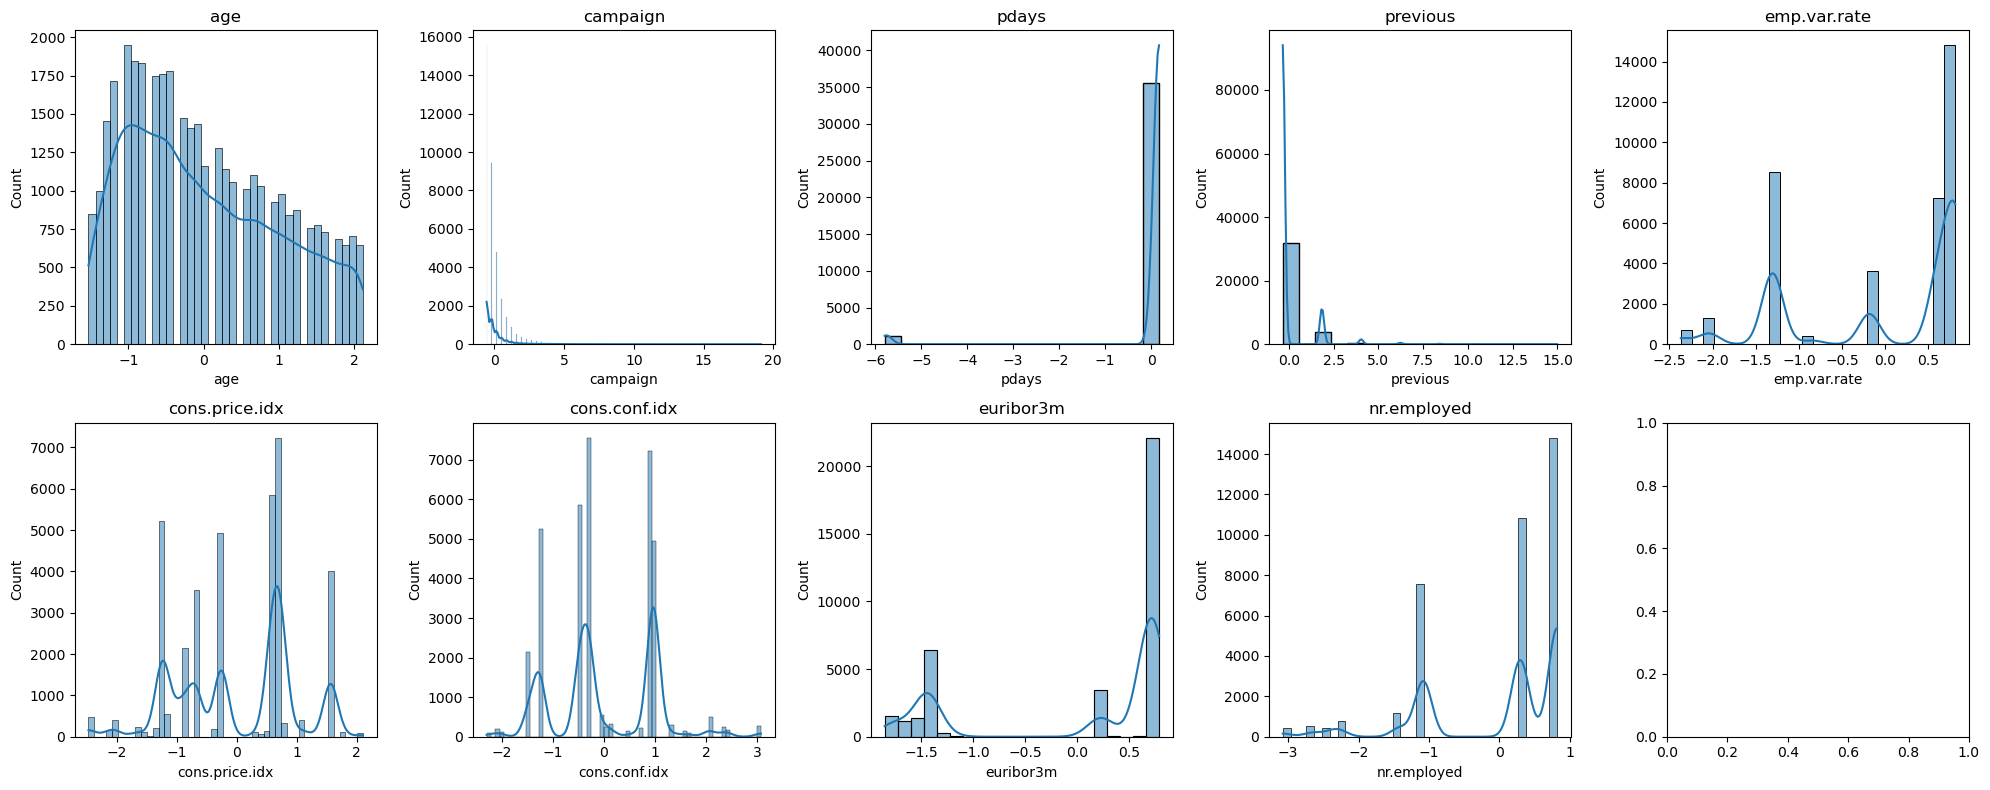

In [191]:
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, feature in enumerate(numerical_features):
    row, col = i // 5, i % 5
    sns.histplot(df[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

# Logarith Transformer

In [30]:
from sklearn.preprocessing import FunctionTransformer

data = df.replace(0, np.nan)
df_clean = data.dropna()

# Apply log transformation only to skewed features
logarithm_transformer = FunctionTransformer(np.log, validate=True)
df_clean[skewed_features] = logarithm_transformer.transform(df_clean[skewed_features])

df = df_clean.copy()

df.head()

age          job  marital          education default housing loan  \
24013   38  blue-collar   single  university.degree      no     yes   no   
24019   40     services  married        high.school      no     yes   no   
24076   36       admin.  married  university.degree      no     yes   no   
24102   36       admin.  married        high.school      no     yes   no   
24108   37       admin.  married  university.degree      no     yes   no   

         contact month day_of_week  ...  campaign     pdays  previous  \
24013  telephone   oct         tue  ... -0.366513  1.932645 -0.366513   
24019  telephone   oct         tue  ... -0.366513  1.932645 -0.366513   
24076  telephone   nov         wed  ... -0.366513  1.932645 -0.366513   
24102  telephone   nov         wed  ... -0.366513  1.932645 -0.366513   
24108  telephone   nov         wed  ... -0.366513  0.665730 -0.366513   

       poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
24013   failure         -0.1          93.798          -40.4      4.968   
24019   failure         -0.1          93.798          -40.4      4.968   
24076   failure         -0.1          93.200          -42.0      4.663   
24102   failure         -0.1          93.200          -42.0      4.286   
24108   success         -0.1          93.200          -42.0      4.286   

       nr.employed    y  
24013       5195.8   no  
24019       5195.8  yes  
24076       5195.8   no  
24102       5195.8  yes  
24108       5195.8   no  

[5 rows x 21 columns]

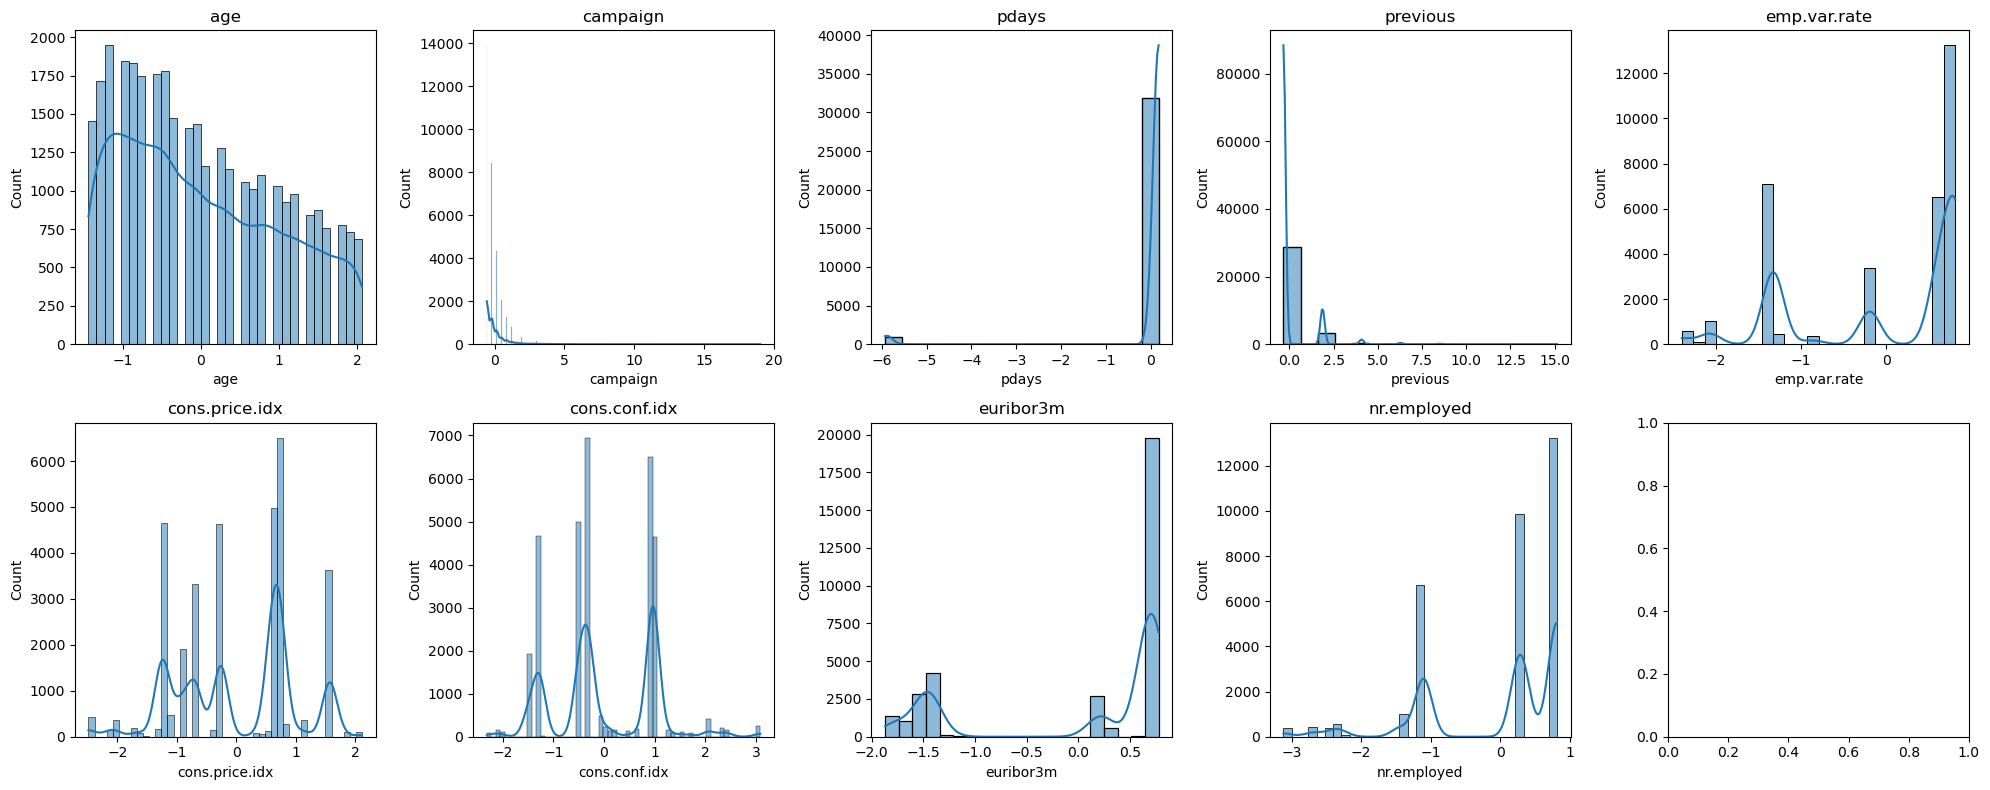

In [89]:
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, feature in enumerate(numerical_features):
    row, col = i // 5, i % 5
    sns.histplot(df[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

# Split Data into Training & Testing Sets

In [147]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['y'])  # Input features
y = df['y']  # Output

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)

X_train Shape: (29273, 19)
X_test Shape: (7319, 19)


# Train & Test Models
### (a) Train Support Vector Machine (SVM)

In [92]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)  # Train the model
svm_pred = svm_model.predict(X_test)  # Make predictions

# Evaluate SVM
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Classification Report:\n", classification_report(y_test, svm_pred))

SVM Accuracy: 0.9050236677355321
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      5903
           1       0.56      0.17      0.26       646

    accuracy                           0.91      6549
   macro avg       0.74      0.58      0.61      6549
weighted avg       0.88      0.91      0.88      6549



### (b) Train Logistic Regression

In [149]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)  # Train the model
lr_pred = lr_model.predict(X_test)  # Make predictions

# Evaluate Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 0.9098237464134444
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      6592
           1       0.68      0.18      0.28       727

    accuracy                           0.91      7319
   macro avg       0.80      0.58      0.62      7319
weighted avg       0.89      0.91      0.89      7319



# Persiting Models


In [ ]:
import joblib

joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(lr_model, 'lr_model.pkl')

# test models
preprocessor = joblib.load("preprocessor.pkl")
svm_model = joblib.load('svm_model.pkl')
lr_model = joblib.load('lr_model.pkl')

# test example
manual_input = pd.DataFrame([{
    'age': 49, 'campaign': 1, 'pdays': 999, 'previous': 0,
    'emp.var.rate': 1.1, 'cons.price.idx': 93.994, 'cons.conf.idx': -36.4,
    'euribor3m': 4.857, 'nr.employed': 5191.0,
    'job': 'technician.', 'marital': 'married', 'education': 'basic.9y', 'default': 'no',
    'housing': 'no', 'loan': 'no', 'contact': 'telephone', 'month': 'may',
    'day_of_week': 'mon', 'poutcome': 'nonexistent'
}])

manual_transformed = preprocessor.transform(manual_input)
prediction = lr_model.predict(manual_transformed)

print("Manual Input Prediction:", prediction)
pd.DataFrame(manual_transformed, columns=numerical_features + categorical_features).head(1)

Manual Input Prediction: [0]


age  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.140555  -0.56611  0.173556 -0.336414      0.611237        0.720994   

   cons.conf.idx  euribor3m  nr.employed  job  marital  education  default  \
0       0.940386   0.671759     0.275371 -1.0      1.0        2.0      0.0   

   housing  loan  contact  month  day_of_week  poutcome  
0      0.0   0.0      1.0    6.0          1.0       1.0

In [173]:
df_before[df_before['y'] == 1].head(3)

age           job   marital          education default housing loan  \
75   41   blue-collar  divorced           basic.4y     NaN     yes   no   
83   49  entrepreneur   married  university.degree     NaN     yes   no   
88   49    technician   married           basic.9y      no      no   no   

      contact month day_of_week  campaign  pdays  previous     poutcome  \
75  telephone   may         mon         1    999         0  nonexistent   
83  telephone   may         mon         1    999         0  nonexistent   
88  telephone   may         mon         1    999         0  nonexistent   

    emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
75           1.1          93.994          -36.4      4.857       5191.0  1  
83           1.1          93.994          -36.4      4.857       5191.0  1  
88           1.1          93.994          -36.4      4.857       5191.0  1

In [176]:
df[df['y'] == 1]

age  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
66     0.169676  -0.56611  0.173556 -0.336414      0.611237        0.720994   
74     1.140555  -0.56611  0.173556 -0.336414      0.611237        0.720994   
79     1.140555  -0.56611  0.173556 -0.336414      0.611237        0.720994   
117    0.169676  -0.56611  0.173556 -0.336414      0.611237        0.720994   
127    0.655115  -0.56611  0.173556 -0.336414      0.611237        0.720994   
...         ...       ...       ...       ...           ...             ...   
36577 -0.922563  -0.56611  0.173556  1.851654     -0.845498        2.099259   
36581 -0.801203  -0.56611  0.173556 -0.336414     -0.845498        2.099259   
36582 -1.043923  -0.56611  0.173556 -0.336414     -0.845498        2.099259   
36587 -0.315764  -0.56611  0.173556 -0.336414     -0.845498        2.099259   
36591  0.533755  -0.56611  0.173556 -0.336414     -0.845498        2.099259   

       cons.conf.idx  euribor3m  nr.employed  job  marital  education  \
66          0.940386   0.671759     0.275371  1.0      0.0        0.0   
74          0.940386   0.671759     0.275371  2.0      1.0        6.0   
79          0.940386   0.671759     0.275371  9.0      1.0        2.0   
117         0.940386   0.671759     0.275371  9.0      1.0        5.0   
127         0.940386   0.671759     0.275371  1.0      1.0        2.0   
...              ...        ...          ...  ...      ...        ...   
36577      -2.296612  -1.611387    -3.076269  0.0      1.0        6.0   
36581      -2.296612  -1.610790    -3.076269  8.0      1.0        5.0   
36582      -2.296612  -1.610790    -3.076269  0.0      2.0        6.0   
36587      -2.296612  -1.612580    -3.076269  0.0      1.0        6.0   
36591      -2.296612  -1.612580    -3.076269  9.0      1.0        5.0   

       default  housing  loan  contact  month  day_of_week  poutcome  y  
66         0.0      1.0   0.0      1.0    6.0          1.0       1.0  1  
74         0.0      1.0   0.0      1.0    6.0          1.0       1.0  1  
79         0.0      0.0   0.0      1.0    6.0          1.0       1.0  1  
117        0.0      1.0   0.0      1.0    6.0          1.0       1.0  1  
127        0.0      1.0   0.0      1.0    6.0          1.0       1.0  1  
...        ...      ...   ...      ...    ...          ...       ... ..  
36577      0.0      0.0   0.0      1.0    7.0          4.0       0.0  1  
36581      0.0      1.0   0.0      1.0    7.0          2.0       1.0  1  
36582      0.0      1.0   0.0      0.0    7.0          2.0       1.0  1  
36587      0.0      1.0   0.0      0.0    7.0          0.0       1.0  1  
36591      0.0      0.0   0.0      0.0    7.0          0.0       1.0  1  

[3570 rows x 20 columns]

In [178]:
df_before.groupby(['job', 'y']).size()


job            y
admin.         0    8447
               1    1175
blue-collar    0    8022
               1     576
entrepreneur   0    1250
               1     116
housemaid      0     843
               1      71
management     0    2428
               1     285
retired        0     546
               1      56
self-employed  0    1171
               1     134
services       0    3312
               1     281
student        0     260
               1      84
technician     0    5681
               1     657
unemployed     0     806
               1     117
dtype: int64